In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

In [2]:
flow_file= "./data/PEMS04/PEMS04.npz"
csv_file = "./data/PEMS04/distance.csv"

In [3]:
# 3 features flow, occupy, speed

In [4]:
import pandas as pd
data = np.load(flow_file)
df = pd.read_csv(csv_file)

In [5]:
df

,from,to,cost
0,73,5,352.6
1,5,154,347.2
2,154,263,392.9
3,263,56,440.8
4,56,96,374.6
...,...,...,...
335,46,216,353.6
336,217,98,411.7
337,98,31,3.2
338,217,46,354.0


In [6]:
df.describe()

,from,to,cost
count,340.000000,340.000000,340.000000
mean,149.544118,146.241176,410.300588
std,88.341793,89.092511,257.518655
min,0.000000,0.000000,3.200000
25%,71.750000,66.750000,328.775000
50%,144.500000,139.500000,367.150000
75%,229.250000,226.500000,422.300000
max,305.000000,306.000000,2712.100000


In [7]:
list(df['from'][:5])

[73, 5, 154, 263, 56]

In [8]:
data['data'].shape

(16992, 307, 3)

In [9]:
df['from'][:5]

0     73
1      5
2    154
3    263
4     56
Name: from, dtype: int64

# Time Series

In [10]:
data = np.load(flow_file)
TS = data['data']

In [11]:
TS.shape

(16992, 307, 3)

In [12]:
#flow,occupy and speed
flow = TS[:,:,0]
occupy = TS[:,:,1]
speed = TS[:,:,2]

In [13]:
# flow dict key is the sensor number and the value the traffic flow times serie
flow_dict={k:flow[:,k] for k in range(307)}
#creation of the datetime index
start_date = "2018-01-01 00:00:00"
end_date = "2018-02-28 23:55:00"
interval = "5min"
index = pd.date_range(start=start_date, end=end_date, freq=interval)

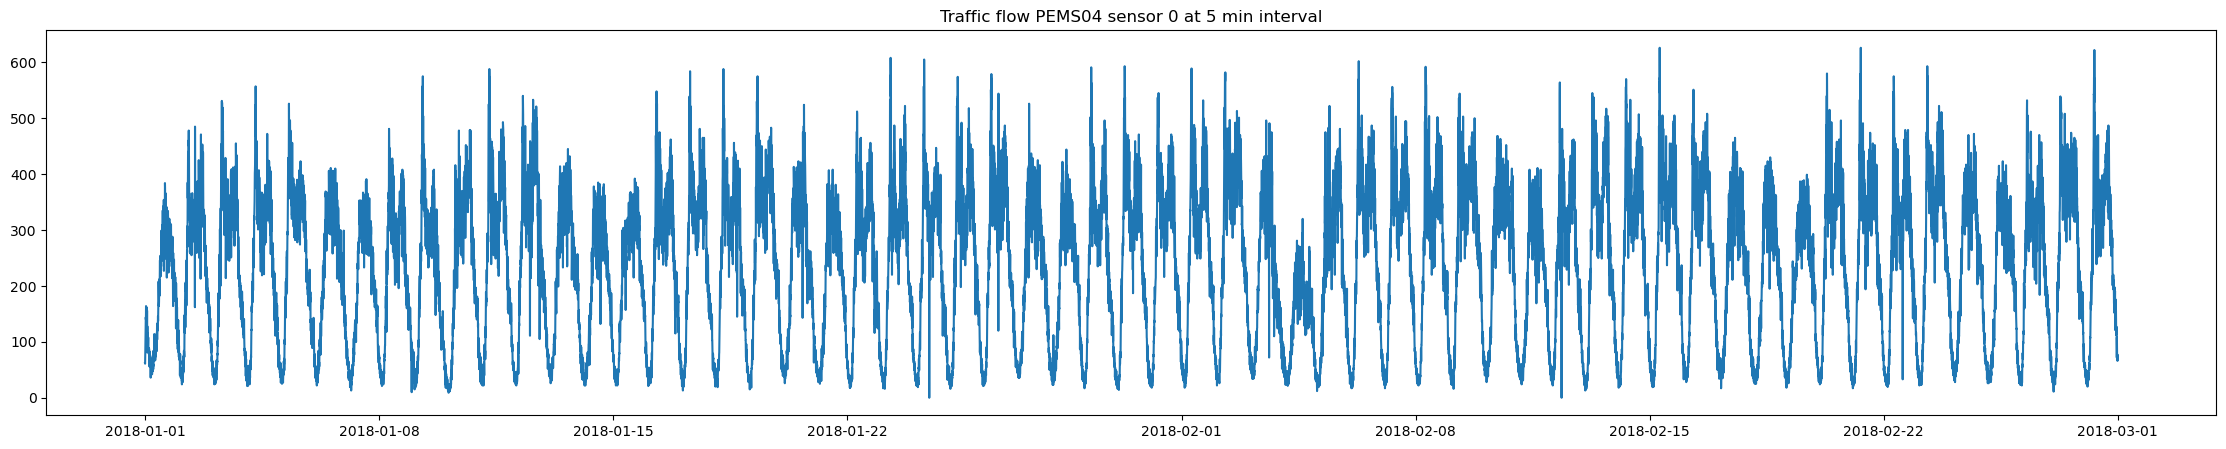

In [14]:
plt.figure(figsize=(28, 5))
plt.plot(index,flow_dict[0])
plt.title('Traffic flow PEMS04 sensor 0 at 5 min interval')
plt.show()
# traffic flow is measure in number of vehicule registered at time t registered in 5 minutes interval.

In [15]:
# list of the first 10 connected sensor, each sensor traffic flow is contained in PeMS 
sensor = set(df['from'][:10])
PeMS = {str(i):flow_dict[i] for i in sensor}

In [16]:
PeMS = pd.DataFrame(PeMS)

In [17]:
PeMS.isna().sum().describe()

count    10.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
dtype: float64

In [18]:
PeMS = PeMS.set_index(index)

In [19]:
105/24

4.375

In [20]:
train_data= PeMS[:'2018-02-10 00:00:00']
val_data =  PeMS['2018-02-10 00:00:00':'2018-02-14 00:00:00']
test_data = PeMS['2018-02-14 00:00:00':]

In [21]:
to_hours = 12
to_days = 12*24
print(len(train_data)/to_days,len(val_data)/to_days,len(test_data)/to_days)

40.00347222222222 4.003472222222222 15.0


In [22]:
n = len(sensor)
print(n)

10


# New LSTM

In [23]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [24]:
# Define a PyTorch dataset to generate input/target pairs for the LSTM model
class TimeSeriesDataset(Dataset):
    def __init__(self, data, window_size, stride):
        self.data = data
        self.window_size = window_size
        self.stride = stride

    def __len__(self):
        return len(self.data) - self.window_size

    def __getitem__(self, idx):
        inputs = self.data[idx:idx+self.window_size]
        target = self.data[idx+self.window_size]
        return inputs, target

In [25]:
# Define your LSTM model here with 6 LSTM layers and 1 fully connected layer
class LSTMModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
        self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [26]:
# Define the sliding window size and stride
window_size = 7
stride = 1
layers = 6
# Create datasets and data loaders for training, validation, and test sets
train_dataset = TimeSeriesDataset(train_data.values, window_size, stride)
val_dataset = TimeSeriesDataset(val_data.values, window_size, stride)
test_dataset = TimeSeriesDataset(test_data.values, window_size, stride)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [27]:
# Instantiate your LSTM model and define the loss function and optimizer
model = LSTMModel(input_size=n, hidden_size=32, num_layers=layers, output_size=n)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [28]:
# Train your model and evaluate on the validation set
num_epochs = 100
best_val_loss = float('inf')
train_losses = []
valid_losses = []
for epoch in range(num_epochs):
    train_loss = 0.0

    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs.float())
        loss = criterion(outputs, targets.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_losses.append(loss.item())
    val_loss = 0.0
    
    for inputs, targets in val_loader:
        outputs = model(inputs.float())
        loss = criterion(outputs, targets.float())
        val_loss += loss.item()
        
    val_loss /= len(val_loader)
    valid_losses.append(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
    
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

Epoch 1/100, Training Loss: 43197104.5625, Validation Loss: 114406.7318
Epoch 2/100, Training Loss: 40432791.3047, Validation Loss: 107398.8889
Epoch 3/100, Training Loss: 37998573.7969, Validation Loss: 100899.1056
Epoch 4/100, Training Loss: 35720394.8906, Validation Loss: 94799.1976
Epoch 5/100, Training Loss: 33570479.9844, Validation Loss: 89049.5299
Epoch 6/100, Training Loss: 31542882.4531, Validation Loss: 83626.7680
Epoch 7/100, Training Loss: 29633160.4023, Validation Loss: 78507.9969
Epoch 8/100, Training Loss: 27826993.1172, Validation Loss: 73666.9361
Epoch 9/100, Training Loss: 26119676.0273, Validation Loss: 69108.1233
Epoch 10/100, Training Loss: 24513957.8750, Validation Loss: 64820.9077
Epoch 11/100, Training Loss: 22999393.0664, Validation Loss: 60779.9425
Epoch 12/100, Training Loss: 21575983.3867, Validation Loss: 56997.6072
Epoch 13/100, Training Loss: 20245651.7617, Validation Loss: 53460.9234
Epoch 14/100, Training Loss: 18999276.4199, Validation Loss: 50155.609

In [29]:
len(train_losses)

36000

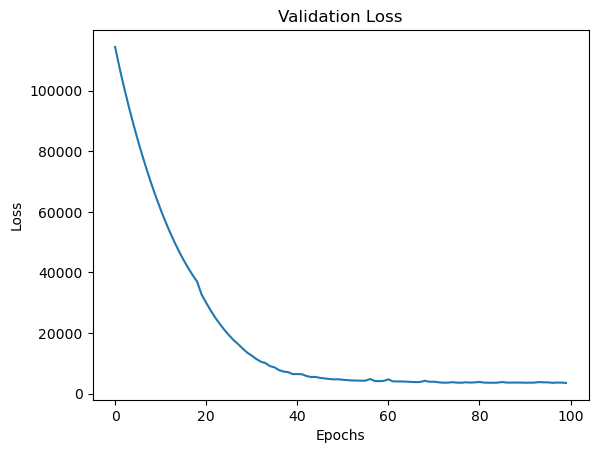

In [30]:
plt.plot(valid_losses,label = 'Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.show()

In [31]:
model

LSTMModel(
  (lstm): LSTM(10, 32, num_layers=6, batch_first=True)
  (fc): Linear(in_features=32, out_features=10, bias=True)
)

In [32]:
# Load the best model and evaluate on the test set
best_model =  LSTMModel(input_size=n, hidden_size=32, num_layers=layers, output_size=n)
best_model.load_state_dict(torch.load('best_model.pth'))
best_model.double()
best_model.eval()

# Evaluate the model on the test set
test_loss = 0.0
predictions = []
actuals = []
with torch.no_grad():
    for i, (inputs, targets) in enumerate(test_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        x = torch.Tensor(inputs).unsqueeze(1).to(device)
        y = torch.Tensor(targets).unsqueeze(0).to(device)
        outputs = best_model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()
        # Save the predictions and actual values for plotting later
        predictions.append(outputs.cpu().numpy())
        actuals.append(targets.cpu().numpy())
test_loss /= len(test_loader)
print(f"Test Loss: {test_loss:.4f}")
# Concatenate the predictions and actuals
predictions = np.concatenate(predictions, axis=0)
actuals = np.concatenate(actuals, axis=0)

Test Loss: 2969.6326


In [33]:
len(inputs)

25

49.66366016735171 67.07787924503027 0.16293432929078278


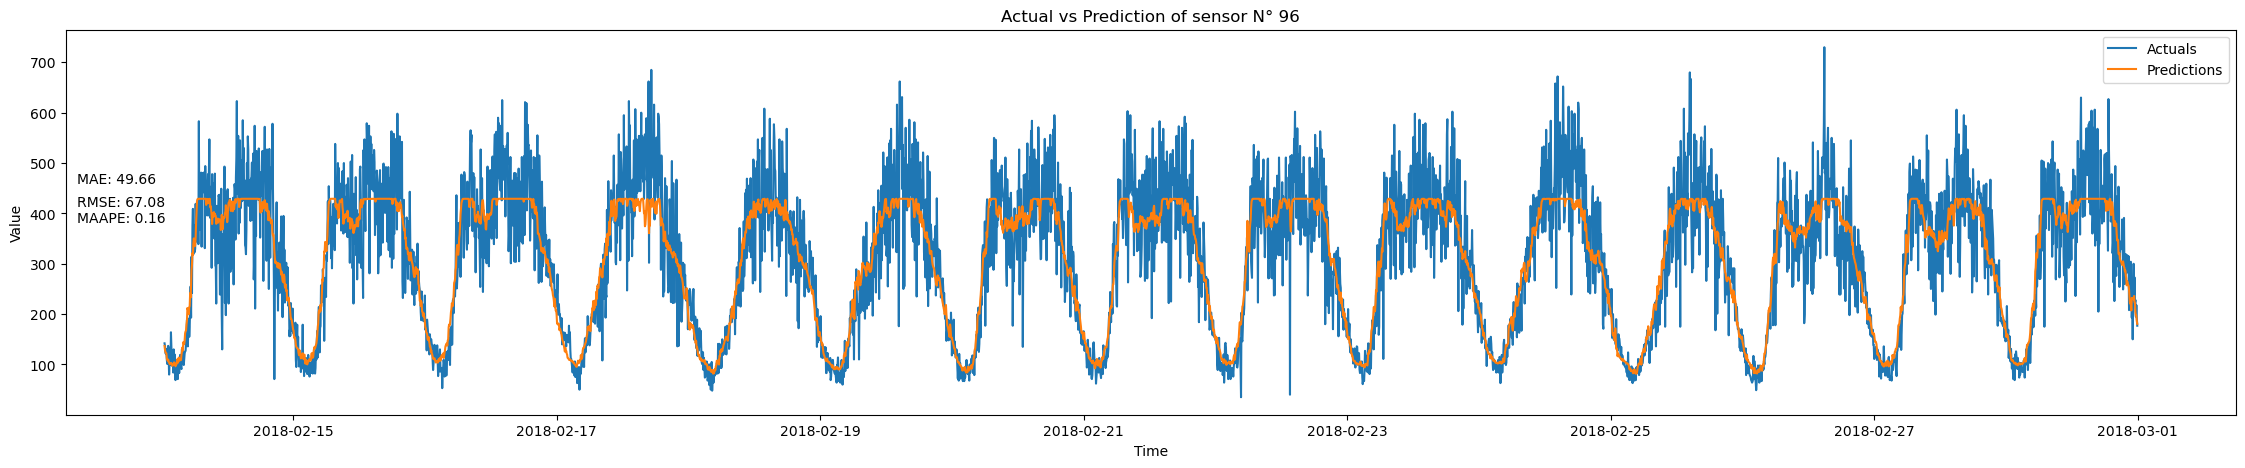

36.13392109939292 48.310333037300666 0.0972275675197575


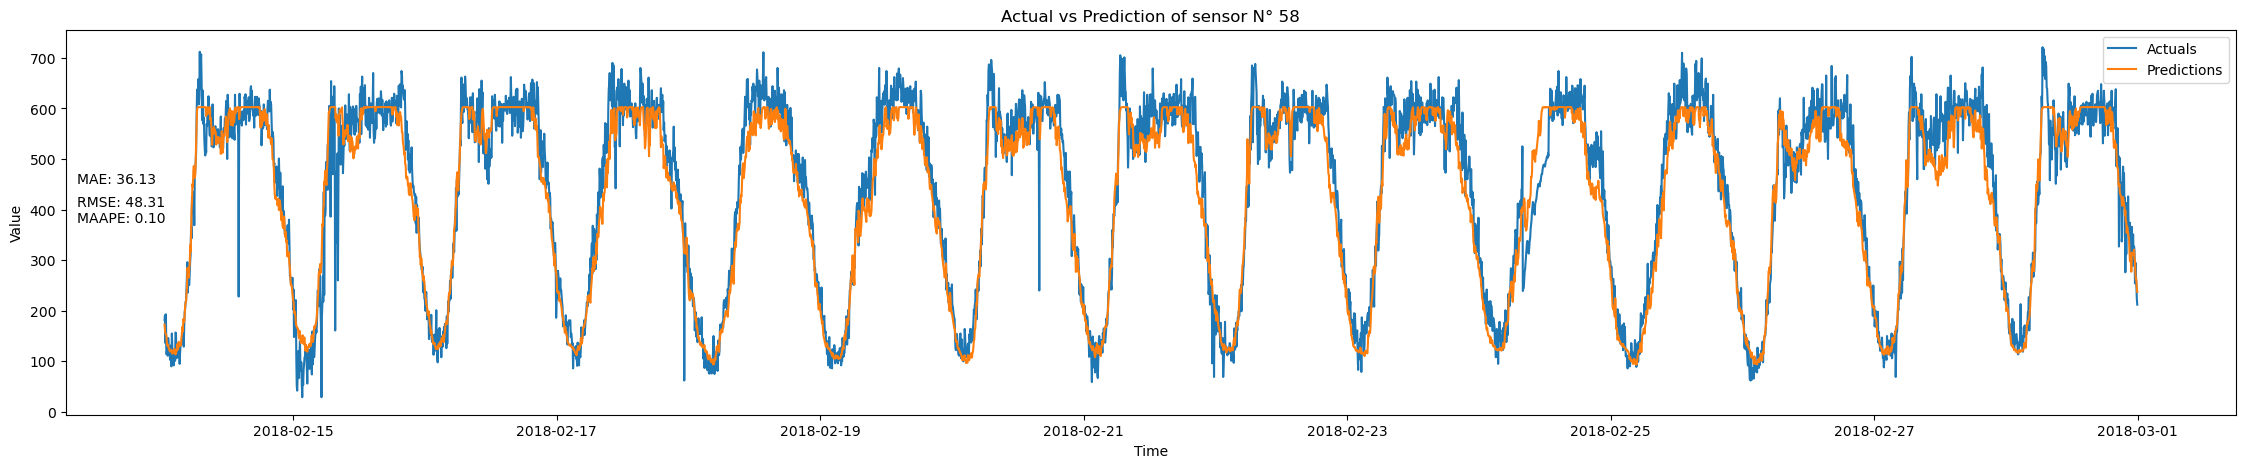

23.43878091090296 31.407362597956855 0.09108604080643548


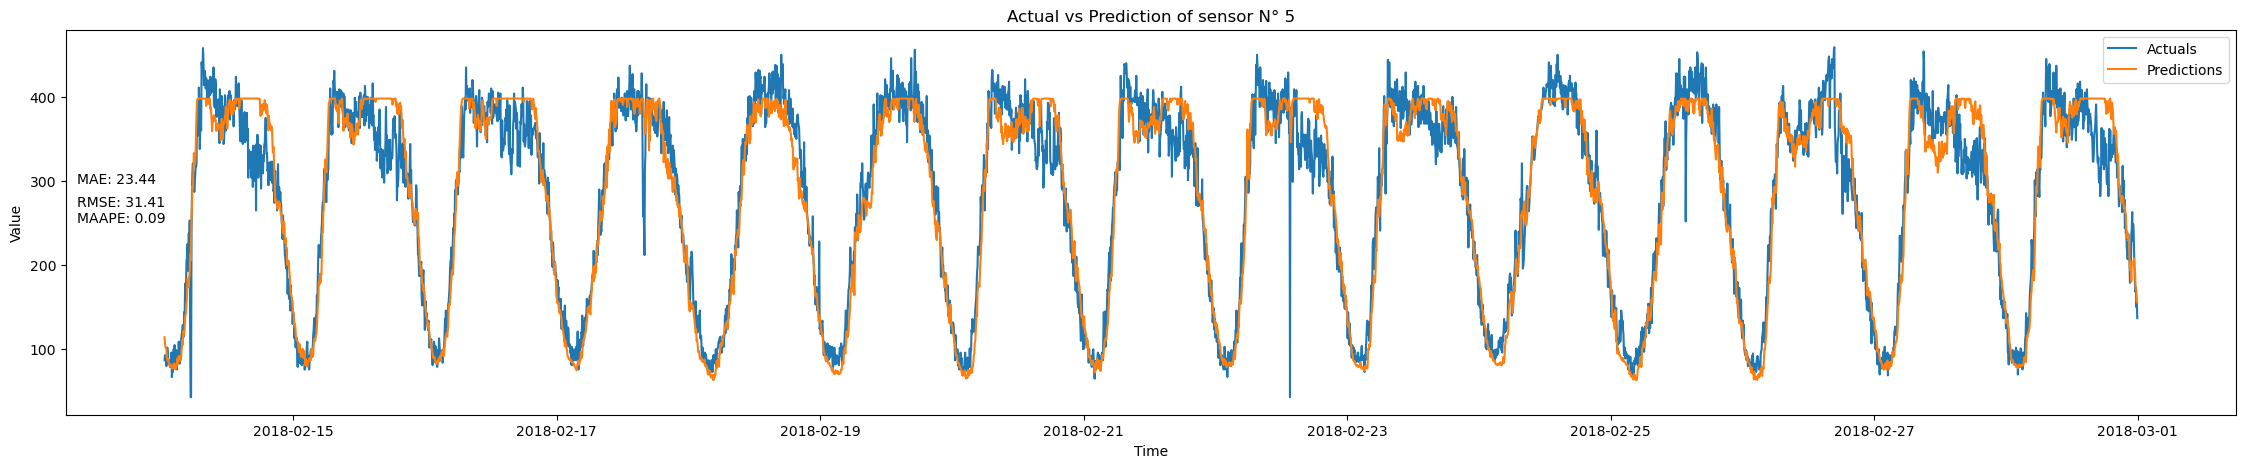

38.16252134206156 53.19418673457784 0.13505752394759468


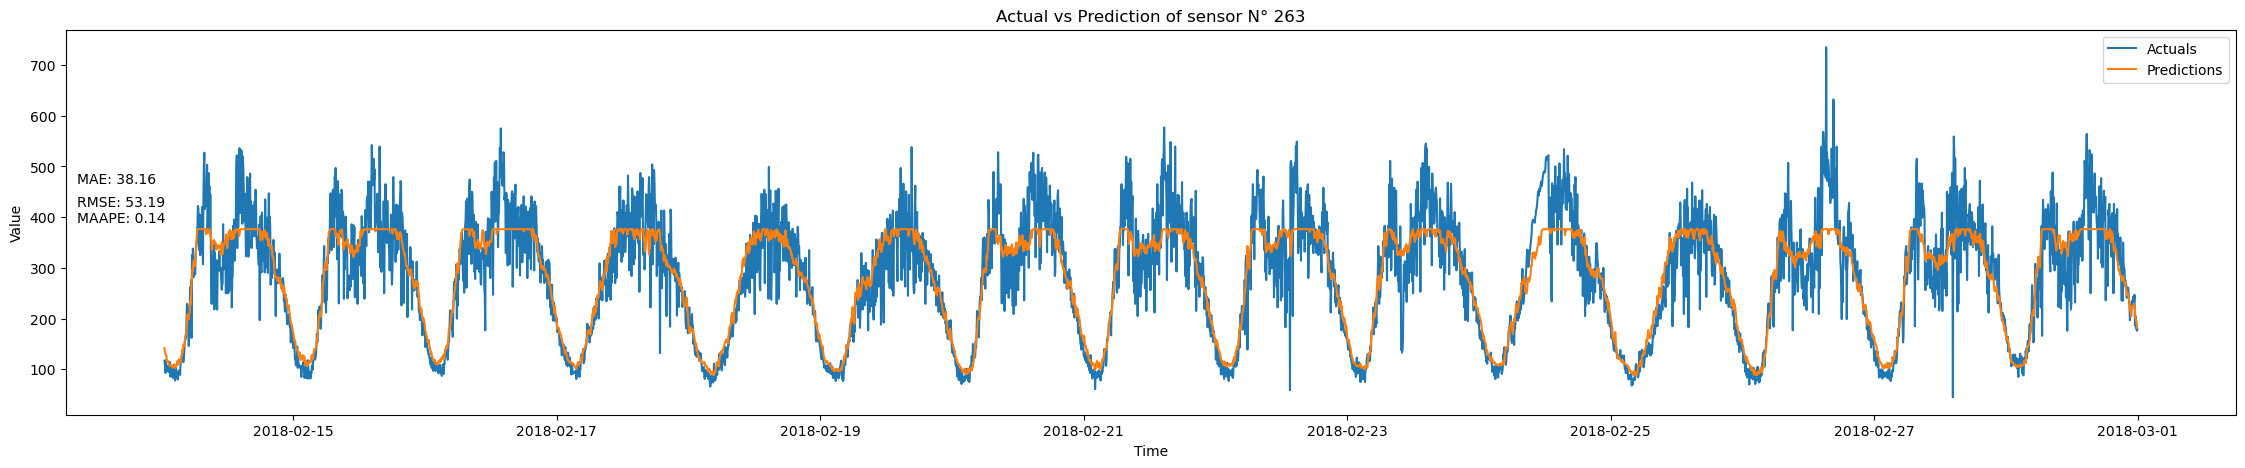

39.05185763656267 55.07894477704206 0.141877317427596


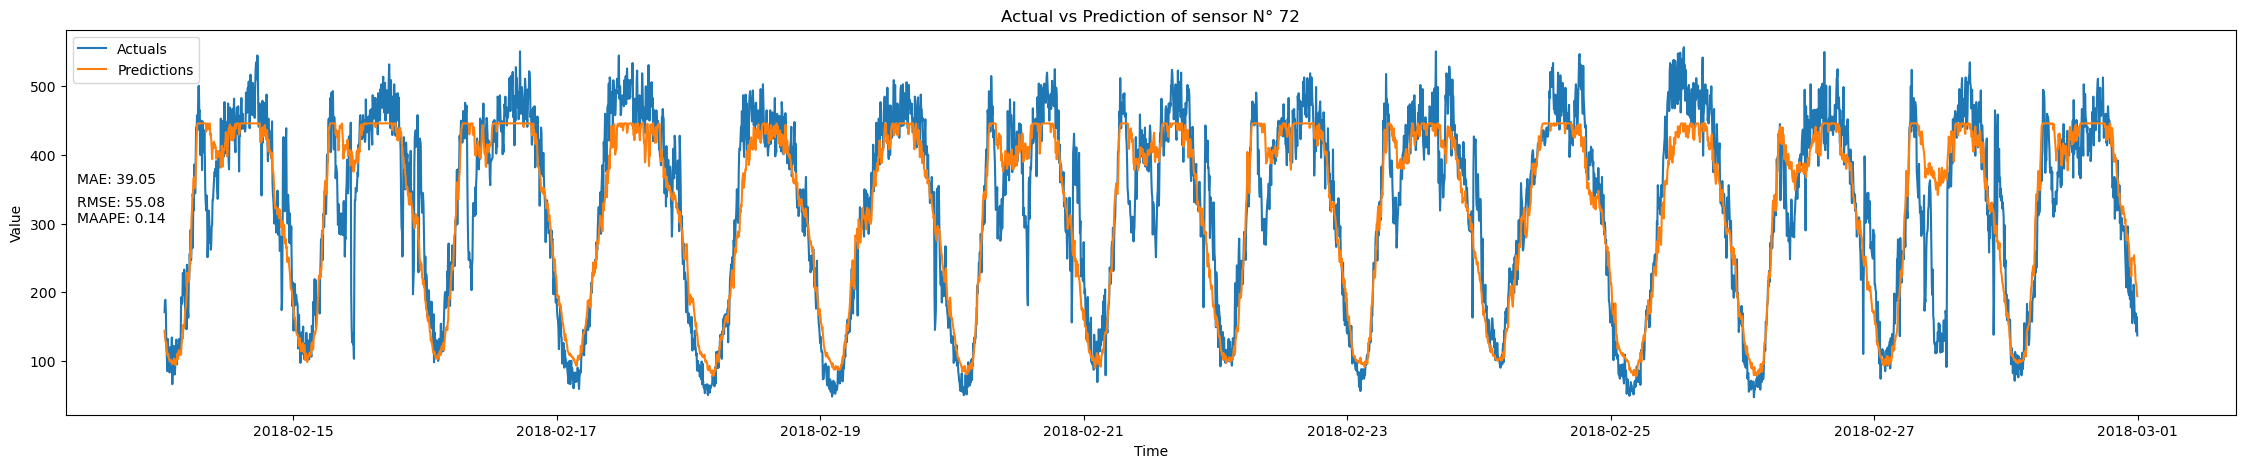

38.9941992245032 53.385784903386636 0.19527581365256957


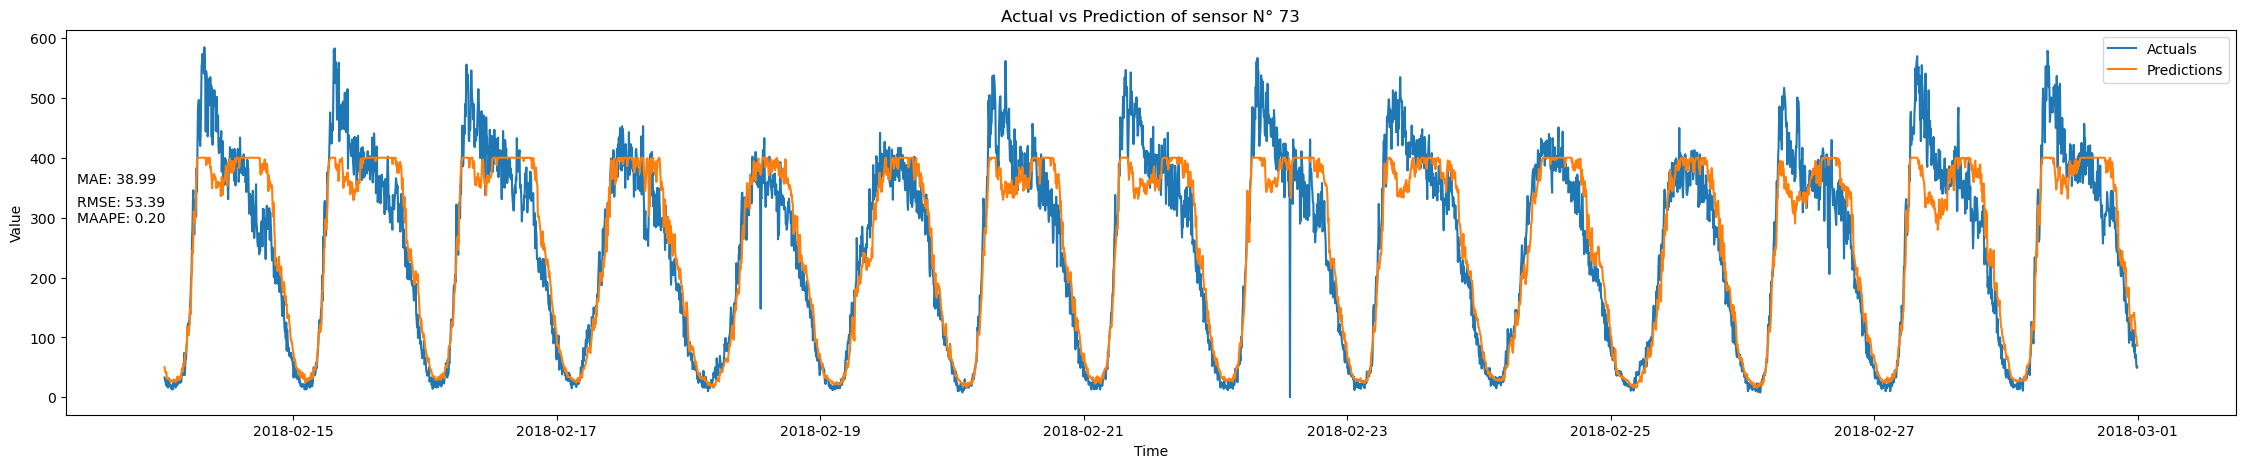

34.804869361880925 48.87392210704037 0.14790670852360596


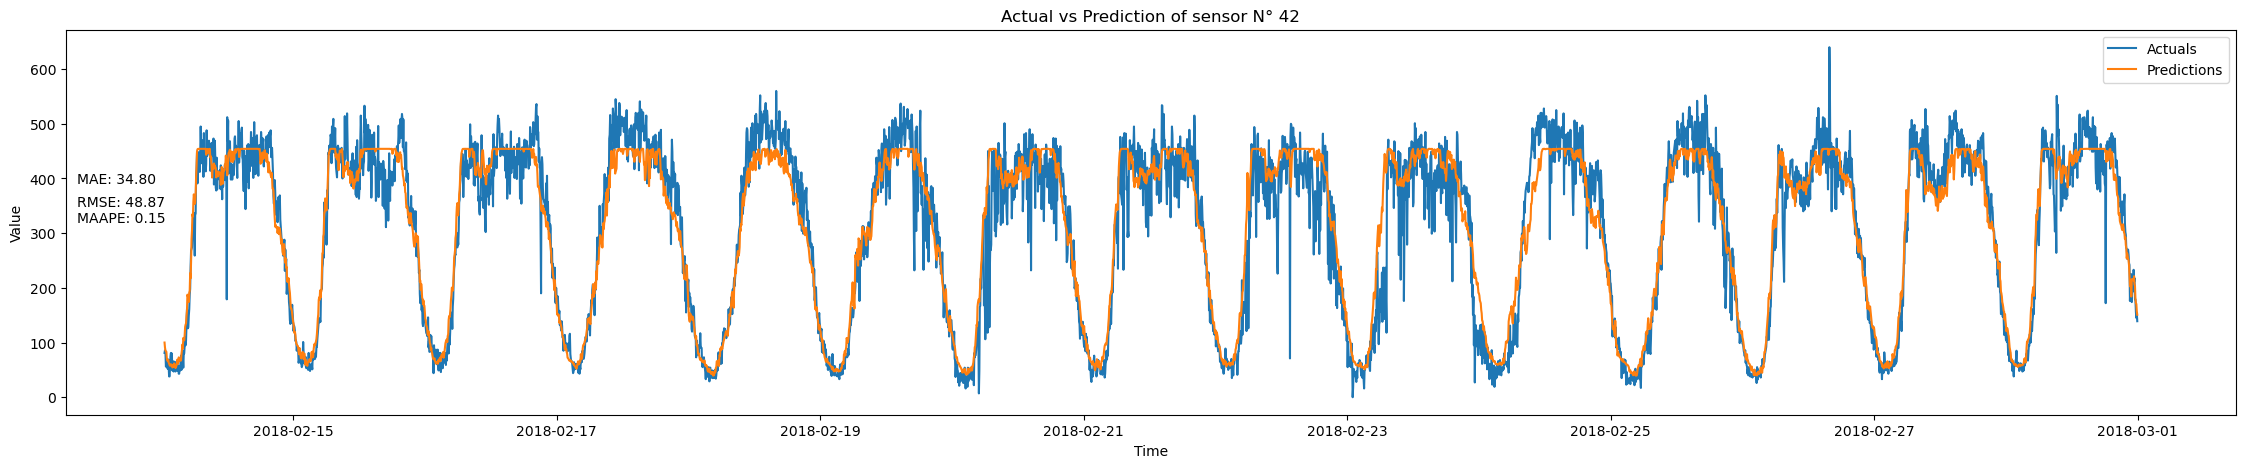

32.08398298212829 42.09851150798217 0.12008842295569835


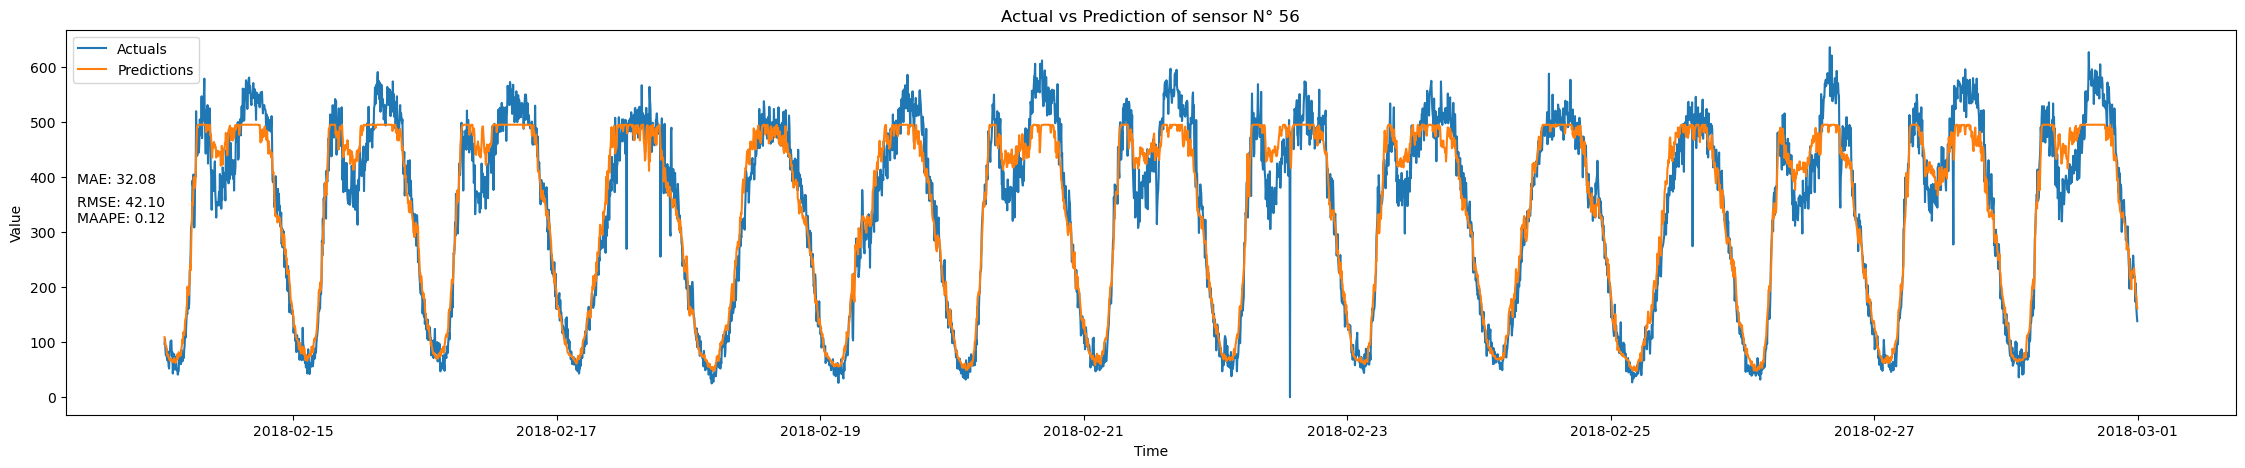

51.84972257997957 65.01078748993623 0.16614258235472715


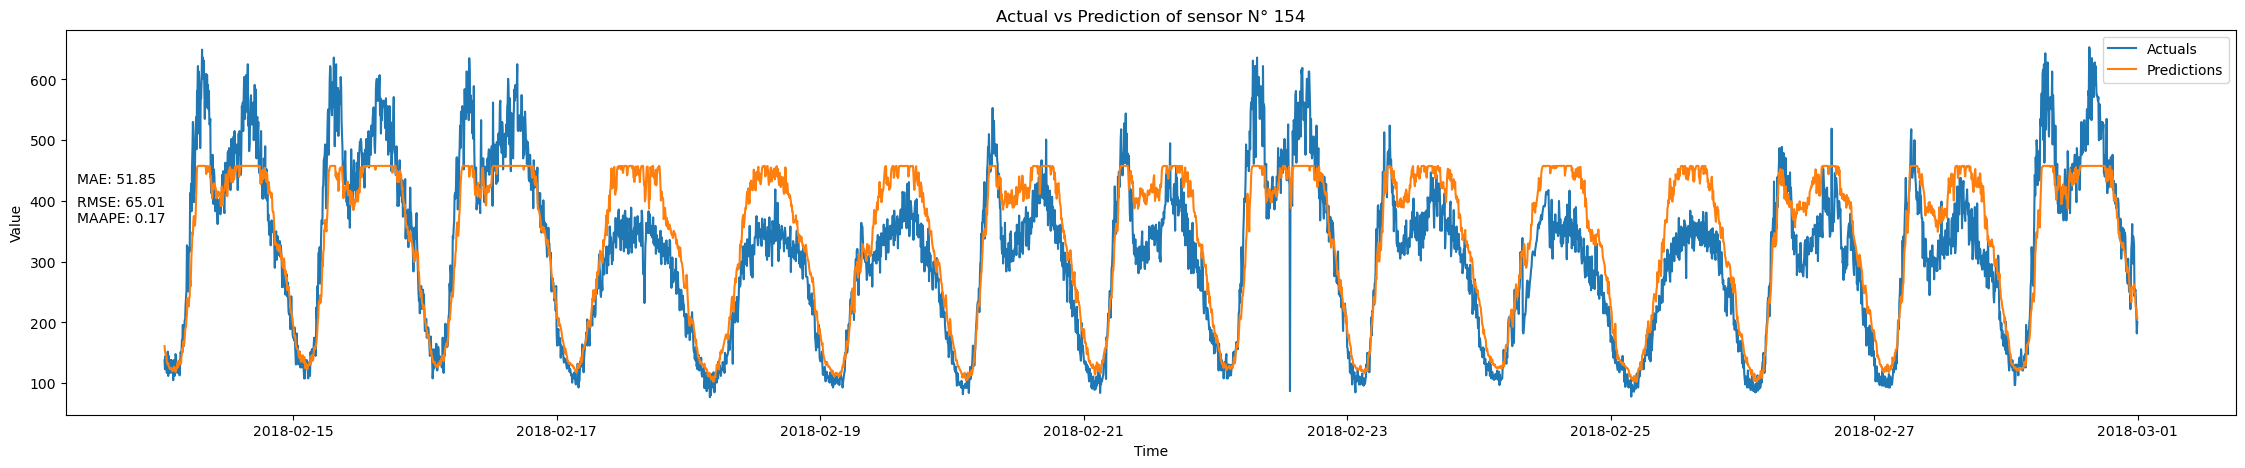

53.33648363177188 69.26474079780267 0.19360974514808785


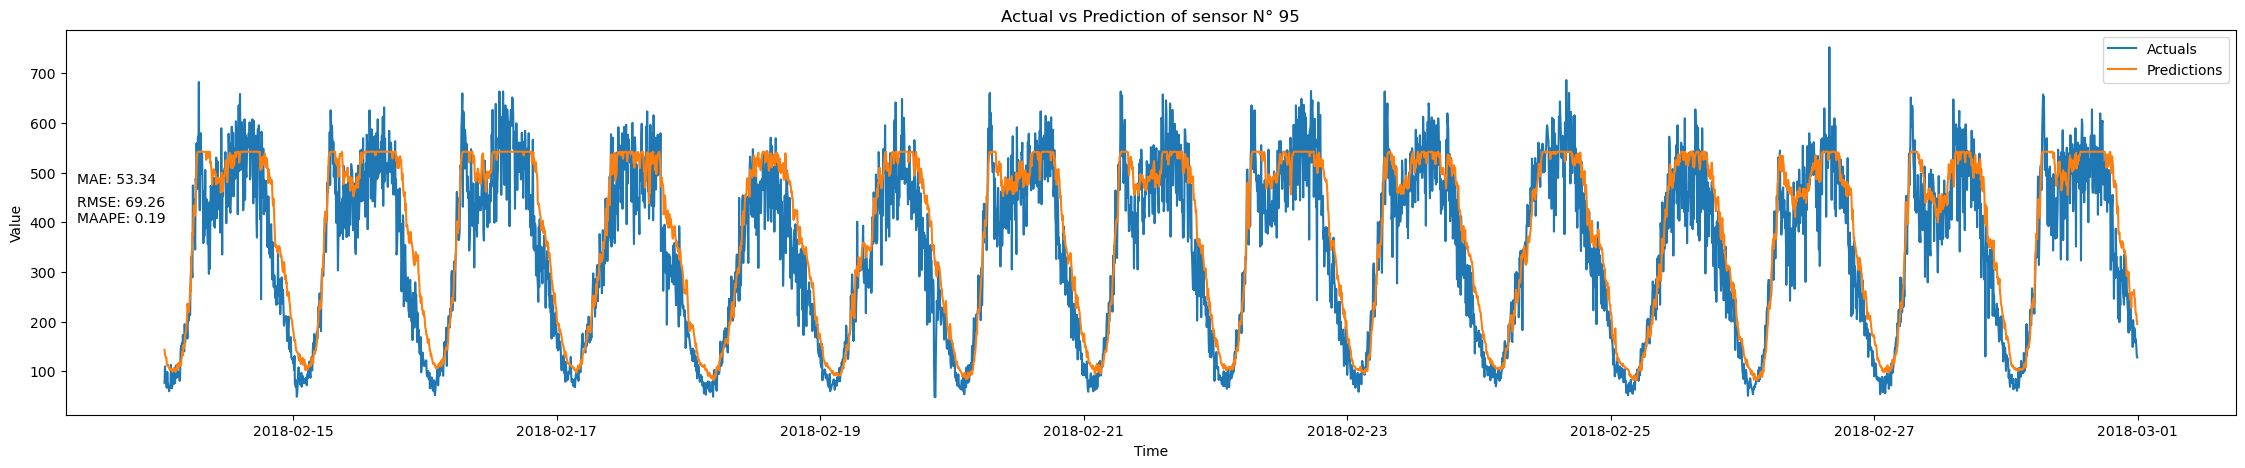

In [34]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from random import randint
EPSILON = 1e-10
for i in range(10): 
    plt.figure(figsize=(28, 5))
    plt.title('Actual vs Prediction of sensor N° {}'.format(PeMS.columns[i]))
    y_pred = predictions[:,i]
    y_true = actuals[:,i]
    plt.plot(test_data.index[window_size:],y_true, label='Actuals')
    plt.plot(test_data.index[window_size:],y_pred, label='Predictions')
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    maape =  np.mean(np.arctan(np.abs((y_true - y_pred) / (y_true + EPSILON))))
    # Add evaluation metrics to the plot
    plt.annotate(f'MAE: {mae:.2f}', xy=(0.005, 0.6), xycoords='axes fraction')
    plt.annotate(f'RMSE: {rmse:.2f}', xy=(0.005, 0.54), xycoords='axes fraction')
    plt.annotate(f'MAAPE: {maape:.2f}', xy=(0.005, 0.5), xycoords='axes fraction')

    # Set x and y labels
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    print(mae,rmse,maape)
    plt.show()
